# LDA for Feature Extraction and Classification
Necessary imports and plot functions used over the entire python notebook:

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from math import log

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
IMAGES_PATH = "./images"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data Retrieval

In [2]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


The functions ```plot_digit()``` and ```plot_digits()``` has been taken from [Aurélien Geron](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb)

In [4]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In the MNIST database, all the digits are placed sequentially. It is important that we shuffle these digits.

In [6]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index].astype(int)

## Linear Discriminant Analysis (LDA)
Doing LDA decomposition involves the following steps:
1. Calculating the class specific mean vector, $\mu_i = 1/n_i \sum_{x\in C_i} x$, where $n_i$ is the size of class $C_i$
2. Caluclate the class-specfic covariance matrix $S_i = \frac{1}{n_i}\sum_{x\in C_i} (x-\mu_i)(x-\mu_i)^T$
3. Calculating the two scatter matrices: the within-class scatter $S_W$ and the between-class scatter $S_B$
<center>$S_W = \sum_{i=1}^C \frac{n_i}{N}S_i = \sum_{i=1}^C P_i S_i$</center>
<center>$S_B = \sum_{i=1}^C P_i (\mu_i-\mu)(\mu_i-\mu)^T$</center>

In [11]:
mu = np.mean(X_train, axis=0)
mu_i = []
for digit in range(10):
    mu_i.append(np.mean(X_train[y_train==digit], axis=0))
print(len(mu_i), mu_i[0].shape)
print(mu[0])
print(mu_i[0][0])

10 (784,)
0.0
0.0


In [8]:
P_i = np.bincount(y_train)/y_train.shape[0]
n_feat = X_train.shape[1]
print(n_feat)
S_W = np.zeros((n_feat, n_feat))

for digit, mu_d in zip(range(10), mu_i):
    S_i = np.zeros((n_feat,n_feat))
    for x in X_train[y_train==digit]:
        x, mu_d = x.reshape(n_feat, 1), mu_d.reshape(n_feat, 1)
        S_i += (x-mu_d).dot((x-mu_d).T)
    S_W += S_i/X_train.shape[0]

784


In [27]:
S_B = np.zeros((n_feat, n_feat))
mu = mu.reshape(n_feat, 1)
for i, mu_d in enumerate(mu_i):
    mu_d = mu_d.reshape(n_feat, 1)
    S_B += P_i[i] * (mu_d-mu).dot((mu_d-mu).T)

In [28]:
S_B

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Once we have the above matrices, we know that the optimal projection matrix $W^*$ has columns $w^*$ which are the eigenvectors of the generalized eigenvalue problem:
<center>$(S_B-\lambda_i S_W)w_i^* = 0$</center>
<center>$\Rightarrow (S_W^{-1}S_B) w_i^* = \lambda w_i^*$</center>

In [29]:
lambdas, w_i = np.linalg.eig(np.linalg.pinv(S_W).dot(S_B))

We now need to sort the eigenvectors according to the eigenvalues. To do this, we covert them into a list of tuples and then sort them based on the eigenvalue.

In [30]:
eig_tuple = [(np.abs(lambdas[i]), w_i[:,i]) for i in range(len(lambdas))]
eig_tuple = sorted(eig_tuple, key= lambda x: x[0], reverse=True)

In [31]:
print('No. of Eignenvalues: ', len(eig_tuple))
print('Eigenvalues in decreasing order:\n')
for i in eig_tuple:
    print(i[0])

No. of Eignenvalues:  784
Eigenvalues in decreasing order:

3.8676896453367533
3.2627296557861967
2.885820554042066
1.7222372186282213
1.5208148687667276
1.1165204151735648
0.8041223228376658
0.5543904517951
0.43301303691589765
1.2682277763249348e-14
1.2504961451205899e-14
1.1310245404245431e-14
1.0366585742597774e-14
1.0337362433424027e-14
1.0337362433424027e-14
9.528780350827304e-15
9.528780350827304e-15
8.595644509686075e-15
8.595644509686075e-15
8.423309478692376e-15
8.423309478692376e-15
8.404552363585998e-15
8.404552363585998e-15
8.298338975548407e-15
8.298338975548407e-15
8.189483093003979e-15
8.189483093003979e-15
7.695181806727598e-15
7.386849913421536e-15
7.386849913421536e-15
7.214477199514482e-15
6.9757473079576686e-15
6.9757473079576686e-15
6.709435642655629e-15
6.709435642655629e-15
6.639035279062434e-15
6.570580241284243e-15
6.367449026133466e-15
6.367449026133466e-15
6.1533852737476e-15
6.1533852737476e-15
6.082553666267643e-15
6.082553666267643e-15
6.0582959834019325e-

Here, we see that the number of eigenvalues is greater than $C-1$. In fact, it is equal to the number of features in the data. However, if we look at the values themselves, we see that only the top 9 values are significant ($C-1$). The remaining values are close to zero, and in fact should be zero. These values are non-zero because of floating point imprecision.

We now plot the strength of the eigenvector vs. the number of eigenvectors taken into consideration. As you can see, just the first eignevalue is much stronger than the other values.

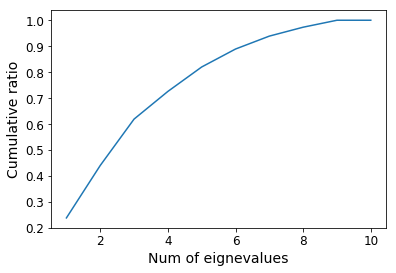

In [49]:
lambda_sorted = sorted(lambdas, reverse=True)
cumsum = np.cumsum(lambda_sorted)
energy = cumsum.real/cumsum[-1].real
plt.xlabel("Num of eignevalues")
plt.ylabel("Cumulative ratio")
plt.plot(np.arange(1, 11), energy[:10])

## Dimensionality Reduction using LDA: $dim = 2$

In [34]:
W_2 = np.hstack((eig_tuple[0][1].real.reshape(n_feat,1), eig_tuple[1][1].real.reshape(n_feat,1)))
Xtrain_lda2 = X_train.dot(W_2)

Saving figure Q2_LDA_2


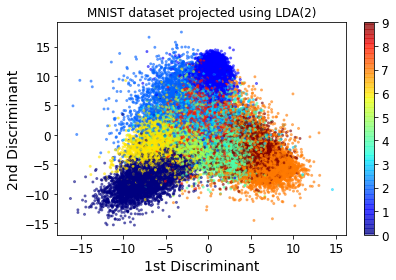

In [35]:
plt.scatter(Xtrain_lda2[:,0], Xtrain_lda2[:,1], c=y_train, cmap='jet', s=4, alpha=0.5)
plt.xlabel('1st Discriminant')
plt.ylabel('2nd Discriminant')
plt.title('MNIST dataset projected using LDA(2)')
# plt.xlim((-0.2,0.2))
plt.colorbar()
save_fig('Q2_LDA_2')

## Dimensionality Reduction using LDA: $dim=3$

In [36]:
W_3 = np.hstack((eig_tuple[0][1].real.reshape(n_feat,1), eig_tuple[1][1].real.reshape(n_feat,1), eig_tuple[2][1].real.reshape(n_feat,1)))
Xtrain_lda3 = X_train.dot(W_3)

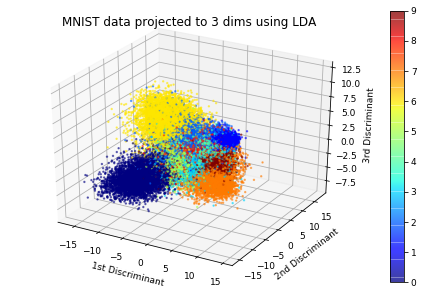

In [37]:
from mpl_toolkits.mplot3d import Axes3D 
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(Xtrain_lda3[:,0], Xtrain_lda3[:,1], Xtrain_lda3[:,2],  c=y_train, cmap='jet', s=2, alpha=0.5)
ax.set_xlabel('1st Discriminant')
ax.set_ylabel('2nd Discriminant')
ax.set_zlabel('3rd Discriminant')
ax.set_title('MNIST data projected to 3 dims using LDA')
# ax.set_xlim((-0.1,0.1))
fig.colorbar(p)
fig.savefig('images/Q2_LDA_3.png',dpi=300)

## Nearest Neigbor with $dim=2$

In [38]:
print(Xtrain_lda2.shape)
print(X_test.dot(W_2).shape)

(60000, 2)
(10000, 2)


In [39]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)  
classifier.fit(Xtrain_lda2, y_train)
ytilde = classifier.predict(X_test.dot(W_2))

0.4741


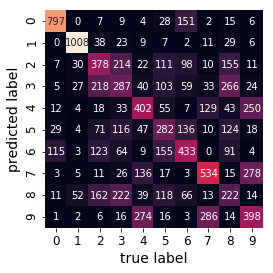

Text(88.68,0.5,'predicted label')

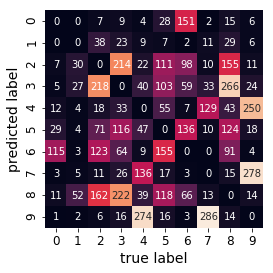

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print(accuracy_score(y_test, ytilde))
mat = confusion_matrix(y_test, ytilde)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
np.fill_diagonal(mat, 0)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')

## Nearest Neigbor with $dim=3$

In [41]:
classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)  
classifier.fit(Xtrain_lda3, y_train)
ytilde = classifier.predict(X_test.dot(W_3))

0.6664


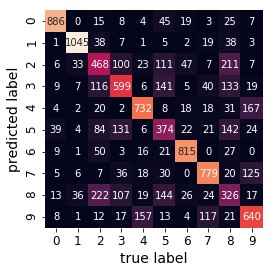

Text(88.68,0.5,'predicted label')

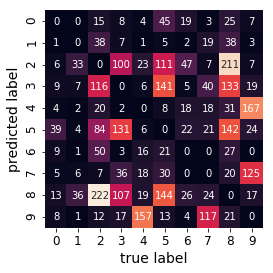

In [42]:
print(accuracy_score(y_test, ytilde))
mat = confusion_matrix(y_test, ytilde)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
np.fill_diagonal(mat, 0)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')

## Nearest Neigbor with $dim=9$

In [43]:
W_9 = np.hstack((i[1].real.reshape(n_feat,1) for i in eig_tuple[:9]))
Xtrain_lda9 = X_train.dot(W_9)

In [44]:
classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)  
classifier.fit(Xtrain_lda9, y_train)
ytilde = classifier.predict(X_test.dot(W_9))

0.895


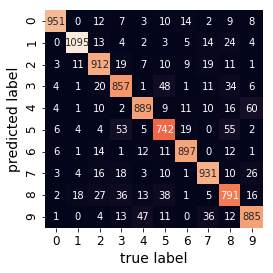

Text(88.68,0.5,'predicted label')

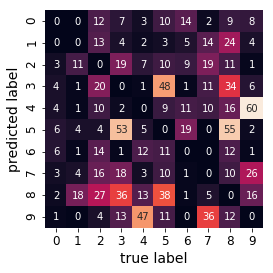

In [45]:
print(accuracy_score(y_test, ytilde))
mat = confusion_matrix(y_test, ytilde)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
np.fill_diagonal(mat, 0)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.xlabel('true label')
plt.ylabel('predicted label')